In [1]:
import numpy as np
import pandas as pd
from itertools import product

# c_bar is the minimum amount to consume
c_bar = 4
# All the money amount are denoted in thousand dollars
earningShock = [-5,5]
# interest rate and return rate
r_f = [0.01 ,0.03]
r_R = [-0.05, 0.25]
r_m = [-0.03, 0.15]
# time line
T_min = 15
T_max = 80
T_y = 65
# discounting factor
beta = 0.98
# tax rate
taxR = 0.20
# participation cost
kappa = 5
# Define transition matrix of economical states
P = np.array([[0.8, 0.2],[0.6, 0.4]])
# Define deterministic function to captures the hump shape of life-cycle earnings.
def chi(age):
    if age in pd.Interval(left=15, right=24,closed = "both"):
        return 35
    elif age in pd.Interval(left=25, right=34,closed = "both"):
        return 54
    elif age in pd.Interval(left=35, right=44,closed = "both"):
        return 67
    elif age in pd.Interval(left=45, right=54,closed = "both"):
        return 71
    elif age in pd.Interval(left=55, right=64,closed = "both"):
        return 61
    else:
        return 37

# Define the utility function
def u(c):
    alpha = 0.88
    sigma = 2
    return ((c**alpha)**(1-sigma) - 1)/(1-sigma)


def transition(Z, a):
    '''
        Input: Z is a tuple containing states variables: (y,b,k,n,I,eps,t)
               u is the action taken at state Z which contains variables: (c, i_b, i_k, i_n)
        Output: the next possible states with corresponding probabilities
    '''
    # Possible future states and corresponding probability
    states = []
    # current state
    y = Z[0]
    b = Z[1]
    k = Z[2]
    n = Z[3]
    I = Z[4]
    # Denote the condition of the economy, 0 stands for bad state and 1 stands for good state
    eps = int(Z[5])
    t = Z[6]
    # current action
    c = a[0]
    i_b = a[1]
    i_k = a[2]
    i_n = a[3]
    # deterministic part of the states
    t_next = t + 1
    if I == 0 and i_k == 0:
        I_next = 0
    else:
        I_next = 1
    # then everything else depends on the economic states
    probs = P[eps]
    for e in [0, 1]:
        y_next = chi(t_next) + earningShock[e]
        b_next = b * (1 + r_f[e]) + i_b
        k_next = k * (1 + r_R[e]) + i_k
        n_next = n * (1 + r_m[e]) + i_n
        eps_next = e
        states.append(np.array([y_next, b_next, k_next, n_next, I_next, eps_next, t_next]))
    return states, probs


def possibleActions(Z, num = 3):
    '''
    Input: the input of this function is the current state: (y,b,k,n,I,eps,t)
    Output: U a list of all possible actions(discretization process): (c, i_b, i_k, i_n)
    '''
    # current state
    y = Z[0]
    b = Z[1]
    k = Z[2]
    n = Z[3]
    I = Z[4]
    eps = Z[5]
    t = Z[6]
    U = []
    if t < T_y:
        for a in product(np.linspace(-b, y, num), 
                         np.linspace(-k, y,num), 
                         np.linspace(0, y,num)):
            i_b, i_k, i_n = a
            c =  -(i_b + i_k + (i_k > 0) * (I==0) * kappa) + (1-taxR) * (y - i_n)
            if (c >= c_bar):
                U.append([c, i_b, i_k, i_n])
            
    else:
        for a in product(np.linspace(-b, y, num),
                         np.linspace(-k, y, num), 
                         np.linspace(-n, 0, num)):
            i_b, i_k, i_n = a
            c = -(i_b + i_k + (i_k > 0) * (I==0) * kappa) + (1-taxR) * y - i_n
            if (c >= c_bar):
                U.append([c, i_b, i_k, i_n])
    return np.array(U)


def V(Z, model = None):
    '''
    Input: the input of this function is the current state: (y,b,k,n,I,eps,t)
    '''
    # if current state is the terminal state
    y = Z[0]
    b = Z[1]
    k = Z[2]
    n = Z[3]
    I = Z[4]
    eps = Z[5]
    t = Z[6]
    if t == T_max:
        return u(b+k+n+y)
    else:
        if model != None:
            # For all possible actions, or probably a sample of those possible actions
            v_max = -100000
            A = possibleActions(Z)
            for a in A:
                c = a[0]
                i_b = a[1]
                i_k = a[2]
                i_n = a[3]
                states, probs = transition(Z, a)
                v = u(c) + beta * np.sum(model.predict(states)*probs)
                if v > v_max:
                    v_max = v
            return v_max

In [2]:
from sklearn.neighbors import KNeighborsRegressor
# state space discretization (y,b,k,n,I,eps,t)
# possible y
Y = np.linspace(30, 75, num = 5)
# possible b
B = np.linspace(0, 75*(T_max-T_min), num = 5)
# possible k
K = np.linspace(0, 75*(T_max-T_min), num = 5)
# possible n
N = np.linspace(0, 75*(T_max-T_min), num = 5)
# possible I
II = [0,1]
# possible eps
EPS = [0,1]

# possible t
T = T_max
# Tensor definition
V_tensorX = np.array([[y,b,k,n,I,eps,T]
                     for y in Y
                     for b in B
                     for k in K
                     for n in N
                     for I in II
                     for eps in EPS
                     ])

V_tensorY = np.array([V(z) for z in V_tensorX])

# To store all the tensors 
XX = []
YY = []
XX.append(np.copy(V_tensorX))
YY.append(np.copy(V_tensorY))

In [3]:
for t in range(T_max - 1, T_min-1, -1):
    print(t)
    # if current state is no the terminal state
    param = 5
    model = KNeighborsRegressor(n_neighbors=param, weights = "distance")
    model.fit(XX[-1], YY[-1])
    # Tensor definition
    V_tensorX = np.array([[y,b,k,n,I,eps,t]
                     for y in Y
                     for b in B
                     for k in K
                     for n in N
                     for I in II
                     for eps in EPS
                     ])
    V_tensorY = []
    i = 0 
    for z in V_tensorX:
        i += 1
        if i%100 == 0:
            print(i)
        V_tensorY.append(V(z, model))
    V_tensorY = np.array(V_tensorY)
        
#     V_tensorY = np.array([V(z, model) for z in V_tensorX])
    XX.append(np.copy(V_tensorX))
    YY.append(np.copy(V_tensorY))

79
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
78
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
77
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
76
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
75
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
74
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
73
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
72
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
71
100
200
300
400
500
600
700
800
900
1000
1100

In [4]:
def VA(Z, XX, YY):
    '''
    Input: the input of this function is the current state: (y,b,k,n,I,eps,t)
    Return: the value and the corresponding action
    '''
    # if current state is the terminal state
    y = Z[0]
    b = Z[1]
    k = Z[2]
    n = Z[3]
    I = Z[4]
    eps = Z[5]
    t = int(Z[6])
    
    X_tensor = XX[-(t- T_min + 1)]
    Y_tensor = YY[-(t- T_min + 1)]
    param = 5
    model = KNeighborsRegressor(n_neighbors=param, weights = "distance")
    model.fit(X_tensor, Y_tensor)
    # For all possible actions, or probably a sample of those possible actions
    v_max = -100000
    A = possibleActions(Z)
    for a in A:
        c = a[0]
        i_b = a[1]
        i_k = a[2]
        i_n = a[3]
        states, probs = transition(Z, a)
        v = u(c) + beta * np.sum(model.predict(states)*probs)
        if v > v_max:
            v_max = v
            a_max = a
    return v_max, a

In [5]:
# Simulation of an agent's life 
Z_time_series = []
Z = [30, 0, 0, 0, 1, 1, 15]
for t in range(T_min, T_max+1):
    v,a = VA(Z, XX, YY)
    states, prob = transition(Z, a)
    Z = states[int(np.random.choice(len(states),1))]
    Z_time_series.append(Z)

In [6]:
import pandas as pd 
C = []
B = []
K = []
N = []
for z in Z_time_series:
    C.append(z[0])
    B.append(z[1])
    K.append(z[2])
    N.append(z[3])
    
d = {'C': C, 'B': B, 'K': K, 'N' : N}
df = pd.DataFrame(d)

Populating the interactive namespace from numpy and matplotlib


/home/hfsluser/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product', 'beta']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


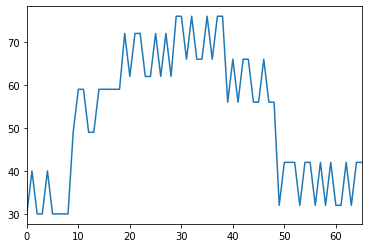

In [7]:
%pylab inline
df.C.plot()

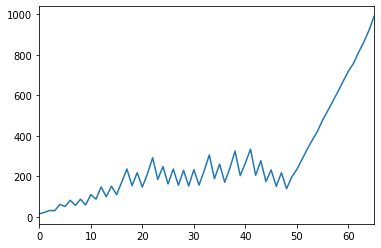

In [8]:
df.B.plot()

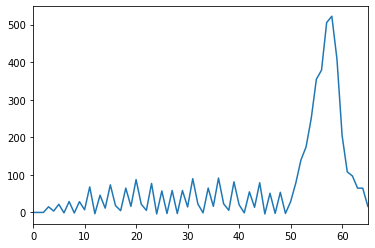

In [9]:
df.K.plot()

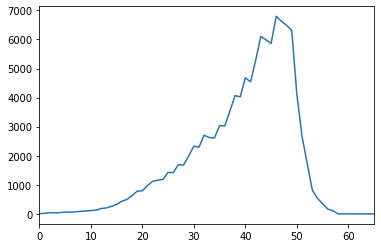

In [10]:
df.N.plot()

In [ ]:
import quantecon as qe